[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.sandbox.google.com/github/kornia/tutorials/blob/master/source/image_matching.ipynb)

# Image matching example with LoFTR

First, we will install everything needed:



*  fresh version of [kornia](https://github.com/kornia/kornia) for [LoFTR](https://zju3dv.github.io/loftr/)
*  fresh version of OpenCV for MAGSAC++ geometry estimation
*  [kornia_moons](https://ducha-aiki.github.io/kornia_moons) for the conversions and visualization


In [1]:
%%capture
!pip install git+https://github.com/kornia/kornia
!pip install kornia_moons
!pip install opencv-python --upgrade

Now let's download an image pair


In [ ]:
%%capture
!wget https://github.com/kornia/data/raw/main/matching/kn_church-2.jpg
!wget https://github.com/kornia/data/raw/main/matching/kn_church-8.jpg

First, we will define image matching pipeline with OpenCV SIFT features. We will also use kornia for the state-of-the-art match filtering -- Lowe ratio + mutual nearest neighbor check and Pydegensac as RANSAC

In [1]:
import matplotlib.pyplot as plt
import cv2
import kornia as K
import kornia.feature as KF
import numpy as np
import torch
from kornia_moons.feature import *

def load_torch_image(fname):
    img = K.image_to_tensor(cv2.imread(fname), False).float() /255.
    img = K.color.bgr_to_rgb(img)
    return img


Bad key "text.kerning_factor" on line 4 in
/home/local/AD/cordun1/anaconda3/envs/gans/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [202]:
def loftr_analysis(fname1, fname2, plot=True, all_features=True):

    img1 = load_torch_image(fname1)
    img2 = load_torch_image(fname2)

    matcher = KF.LoFTR(pretrained='outdoor')

    input_dict = {"image0": K.color.rgb_to_grayscale(img1), # LofTR works on grayscale images only 
                  "image1": K.color.rgb_to_grayscale(img2)}

    with torch.no_grad():
        correspondences = matcher(input_dict)
    #for k,v in correspondences.items():
    #print (k)
    
    mkpts0 = correspondences['keypoints0'].cpu().numpy()
    mkpts1 = correspondences['keypoints1'].cpu().numpy()
    """
    Output
    F Fundamental matrix, 3x3 (or 9x3 in some cases, see below).
    mask Optional output mask set by a robust method (RANSAC or LMedS), indicates inliers. Vector of same length as number of points.
    """
    H, inliers = cv2.findFundamentalMat(mkpts0, mkpts1, cv2.USAC_MAGSAC, 0.5, 0.999, 100000) # cv2.USAC_MAGSAC best - https://ducha-aiki.github.io/wide-baseline-stereo-blog/2021/05/17/OpenCV-New-RANSACs.html

    inliers = inliers > 0

    print("Number of inliers:", len(inliers))
    #print("Fundamental Matrix:", H)
    
    # draw_LAF_matches comes from Kornia.moon - https://ducha-aiki.github.io/kornia_moons/feature.html#draw_LAF_matches
    if plot and not all_features:
        draw_LAF_matches(KF.laf_from_center_scale_ori(torch.from_numpy(mkpts0).view(1,-1, 2),
                                torch.ones(mkpts0.shape[0]).view(1,-1, 1, 1),
                                torch.ones(mkpts0.shape[0]).view(1,-1, 1)),
                         KF.laf_from_center_scale_ori(torch.from_numpy(mkpts1).view(1,-1, 2),
                                torch.ones(mkpts1.shape[0]).view(1,-1, 1, 1),
                                torch.ones(mkpts1.shape[0]).view(1,-1, 1)),
                         torch.arange(mkpts0.shape[0]).view(-1,1).repeat(1,2),
                         K.tensor_to_image(img1),
                         K.tensor_to_image(img2),
                         inliers,
                         draw_dict={'inlier_color': (0.2, 1, 0.2),
                                    'tentative_color': None,
                                    'feature_color': (0.2, 0.5, 1), 'vertical': False})
    elif plot and all_features: 
        draw_LAF_matches(KF.laf_from_center_scale_ori(torch.from_numpy(mkpts0).view(1,-1, 2),
                                torch.ones(mkpts0.shape[0]).view(1,-1, 1, 1),
                                torch.ones(mkpts0.shape[0]).view(1,-1, 1)),
                         KF.laf_from_center_scale_ori(torch.from_numpy(mkpts1).view(1,-1, 2),
                                torch.ones(mkpts1.shape[0]).view(1,-1, 1, 1),
                                torch.ones(mkpts1.shape[0]).view(1,-1, 1)),
                         torch.arange(mkpts0.shape[0]).view(-1,1).repeat(1,2),
                         K.tensor_to_image(img1),
                         K.tensor_to_image(img2),
                         inliers,
                         draw_dict={'inlier_color': (0.2, 1, 0.2),
                                    'tentative_color': (0.8, 0.8, 0), #draws yellow lines on tentative feature matches
                                    'feature_color': (0.2, 0.5, 1), 'vertical': False})
        
    angles = []
    for i in range(0, len(inliers)):
        dY = mkpts1[i][1] - mkpts0[i][1]
        dX = mkpts1[i][0] - mkpts0[i][0]
        angle = np.degrees(np.arctan2(dY, dX)) 
        angles.append(angle)
        
    #print(mkpts0)
    #print(mkpts1)
    f = np.where((np.array(angles)<= 50.0) & (np.array(angles) >= -50.0))
    g = np.where(abs(np.array(angles)) <= 5.0)
    #print(abs(np.array(angles)))
    #print(g)
    #print("Keypoints are symmetrical:", len(f[0]))
    #print("Perc of all keypoints that are +/- < 50 deg variant: {:.2f}% ".format(len(f[0])/len(inliers) * 100))
    print("Perc of all keypoints that are < 5 deg variant: {:.2f}% ".format(len(g[0])/len(inliers) * 100))
    #print(angles)
    print("Average angle between inliers:", np.array(angles).mean())
    print("Average using abs values:", abs(np.array(angles)).mean())
 

**About `arctan2()` vs. `arctan()` **

Each in Python is complimentary to C++ version. 
FYI: `arctan2 is identical to the atan2 function of the underlying C library.`
Ref: https://numpy.org/doc/stable/reference/generated/numpy.arctan2.html

`atan(y/x)` is held back some information and can only assume that the input came from quadrants I or IV. In contrast, `atan2(y,x)` gets all the data and thus can resolve the correct angle.

Ref: https://stackoverflow.com/questions/283406/what-is-the-difference-between-atan-and-atan2-in-c
Ref: https://numpy.org/doc/stable/reference/generated/numpy.arctan.html

In [203]:
og_A = './preproc_experiments/A_test/' #regular
al_A = './preproc_experiments/aligned/A_test/resized/' #aligned

og_B = './preproc_experiments/B_test/' # regular 
al_B = './preproc_experiments/aligned/B_test/resized/' # aligned

#file = 'SUBJ1b2c70ec_e_2019-11-14_13-13-16-611.png'
#file = 'SUBJ7b939e92_e_2019-11-04_16-28-19-516.png' # In my weeekly 5 report
#file = 'SUBJ2fcfbead_b_2019-11-15_13-28-55-374.png' # glasses
file = 'SUBJcd219e22_e_2019-11-14_16-49-26-200.png' # asian

fname1 = al_A + file
fname2 = al_B + file

Number of inliers: 24
Perc of all keypoints that are < 5 deg variant: 0.00% 
Average angle between inliers: 20.046804
Average using abs values: 140.92853
Average euclidean dist: 40.00347295852523
[125.96381736034556, 128.3658467255541, 35.12880526818994, 20.100221392462316, 23.034679155277523, 22.485097600785913, 52.45392440858651, 52.49911752347109, 85.57708574913718, 46.18364259650298, 50.241379815871724, 9.882415673144543, 8.513415332593278, 8.077322322648884, 8.004974318119103, 8.780949022155971, 8.189819085205487, 0.9004182798698569, 41.257343680950385, 83.44385535501894, 21.35324051947006, 8.329908081414857, 72.23701745172686, 39.0790542861024]


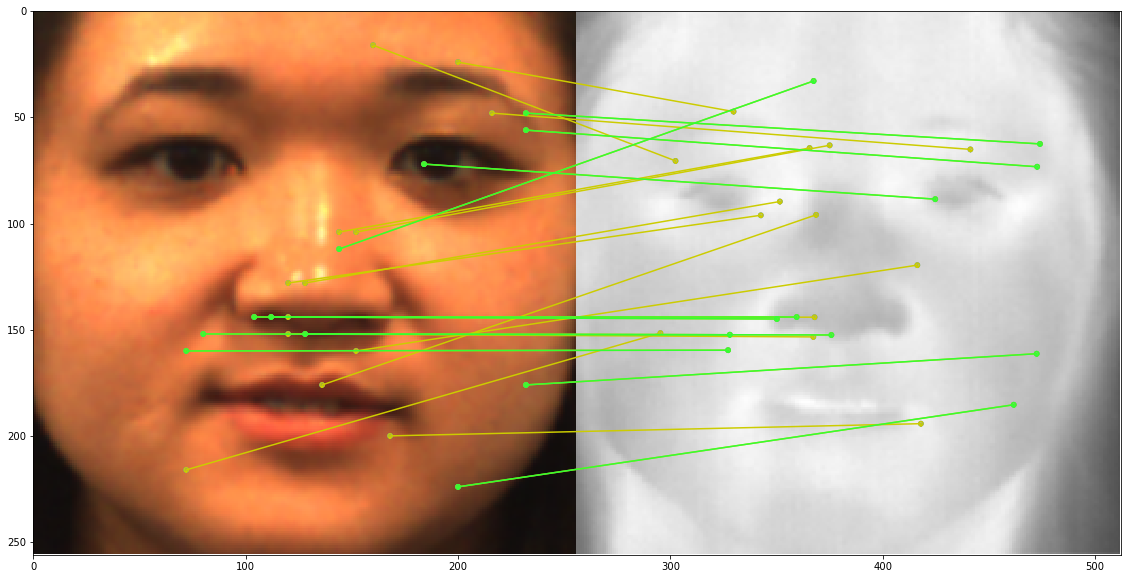

In [204]:
# Both aligned
loftr_analysis(fname1, fname2, plot=True, all_features=True)

Number of inliers: 51
Perc of all keypoints that are < 5 deg variant: 0.00% 
Average angle between inliers: -75.69502
Average using abs values: 94.23519
Average euclidean dist: 48.41515986950796


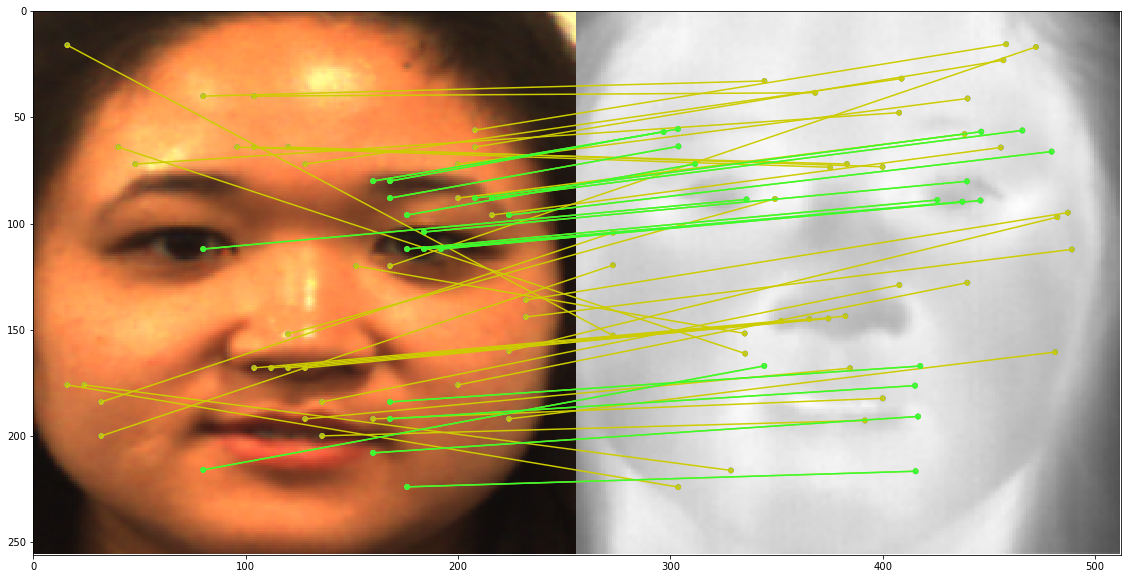

In [200]:
# Original A, Aligned B
fname1 = og_A + file
fname2 = al_B + file
loftr_analysis(fname1, fname2, plot=True, all_features=True)

Number of inliers: 62
Perc of all keypoints that are < 5 deg variant: 6.45% 
Average angle between inliers: 21.050161
Average using abs values: 70.132576
Average euclidean dist: 27.246138675779974


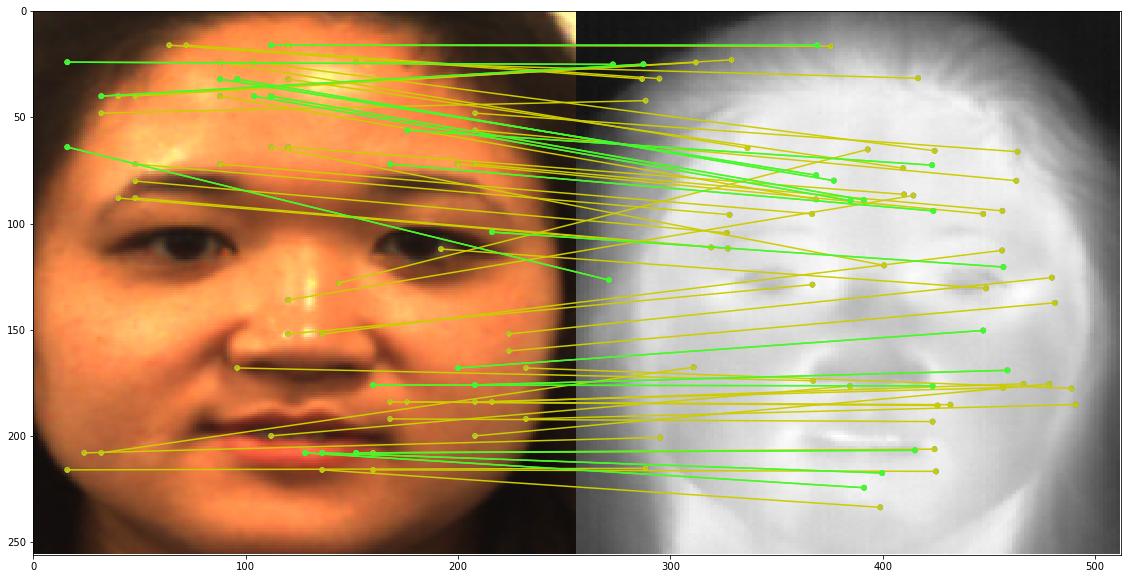

In [201]:
fname1 = og_A + file
fname2 = og_B + file
# Original A, Original B
loftr_analysis(fname1, fname2, plot=True, all_features=True)

Number of inliers: 784
[[ 16.  16.]
 [ 24.  16.]
 [ 32.  16.]
 ...
 [216. 232.]
 [224. 232.]
 [232. 232.]]
[[ 16.10388   16.084259]
 [ 24.018234  15.940612]
 [ 31.902163  16.046629]
 ...
 [215.98915  232.1511  ]
 [224.03778  232.24666 ]
 [231.88133  231.92796 ]]
Perc of all keypoints that are < 5 deg variant: 2.81% 
Average angle between inliers: 25.974447
Average using abs values: 95.21791


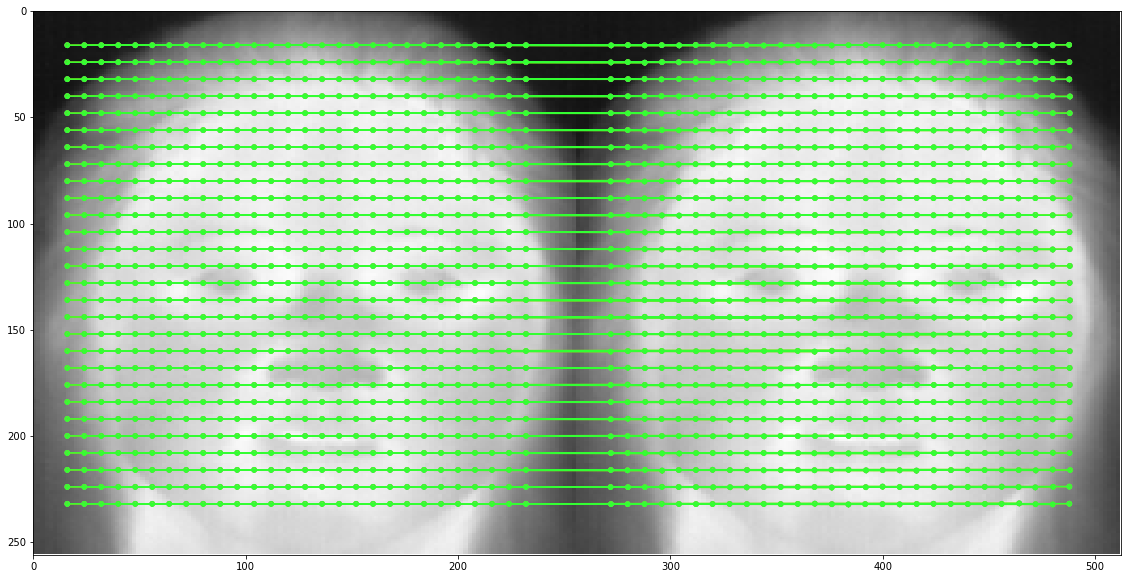

In [187]:
# Toy Test example - how straight are the lines when they are the same image? 
fname2 = og_B + file
loftr_analysis(fname2, fname2, plot=True, all_features=True)

Number of inliers: 784
Perc of all keypoints that are < 5 deg variant: 2.30% 
Average angle between inliers: 22.021883
Average using abs values: 100.575035


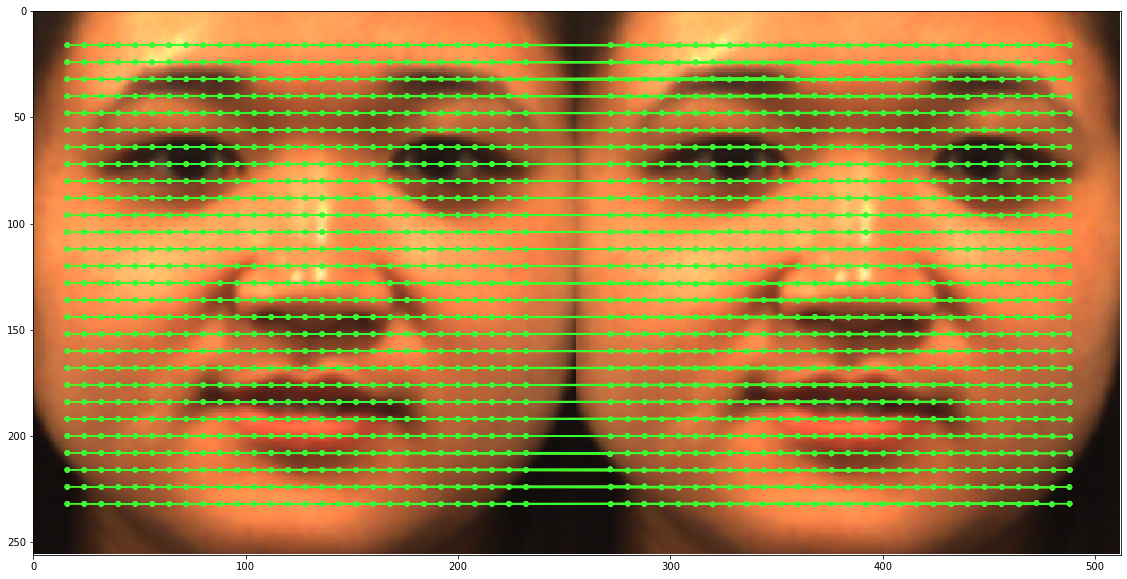

In [183]:
fname1 = al_A + file
loftr_analysis(fname1, fname1, plot=True, all_features=True)

# Original implementations / scratch work

In [7]:
og_A = './preproc_experiments/A_test/' #regular
al_A = './preproc_experiments/aligned/A_test/resized/' #aligned

og_B = './preproc_experiments/B_test/' # regular 
al_B = './preproc_experiments/aligned/B_test/resized/' # aligned

#file = 'SUBJ1b2c70ec_e_2019-11-14_13-13-16-611.png'
file = 'SUBJ7b939e92_e_2019-11-04_16-28-19-516.png'

fname1 = al_A + file
fname2 = al_B + file

img1 = load_torch_image(fname1)
img2 = load_torch_image(fname2)


matcher = KF.LoFTR(pretrained='outdoor')

input_dict = {"image0": K.color.rgb_to_grayscale(img1), # LofTR works on grayscale images only 
              "image1": K.color.rgb_to_grayscale(img2)}

with torch.no_grad():
    correspondences = matcher(input_dict)

In [8]:
for k,v in correspondences.items():
    print (k)

keypoints0
keypoints1
confidence
batch_indexes


Now let's clean-up the correspondences with modern RANSAC and estimate fundamental matrix between two images

In [9]:
mkpts0 = correspondences['keypoints0'].cpu().numpy()
mkpts1 = correspondences['keypoints1'].cpu().numpy()
"""
Output
F Fundamental matrix, 3x3 (or 9x3 in some cases, see below).
mask Optional output mask set by a robust method (RANSAC or LMedS), indicates inliers. Vector of same length as number of points.
"""
H, inliers = cv2.findFundamentalMat(mkpts0, mkpts1, cv2.USAC_MAGSAC, 0.5, 0.999, 100000) # cv2.USAC_MAGSAC best - https://ducha-aiki.github.io/wide-baseline-stereo-blog/2021/05/17/OpenCV-New-RANSACs.html

inliers = inliers > 0
print(len(inliers))
print("Fundamental Matrix:", H)

34
Fundamental Matrix: [[ 4.34428731e-05  4.50993558e-05  3.45335734e-03]
 [ 1.51757739e-04  3.75204240e-05 -3.12134934e-02]
 [-4.18734285e-02 -1.58432653e-02  6.63279819e+00]]


Finally, let's draw the matches with a function from [kornia_moons](https://ducha-aiki.github.io/kornia_moons/feature.html#draw_LAF_matches). The correct matches are in green and imprecise matches - in blue

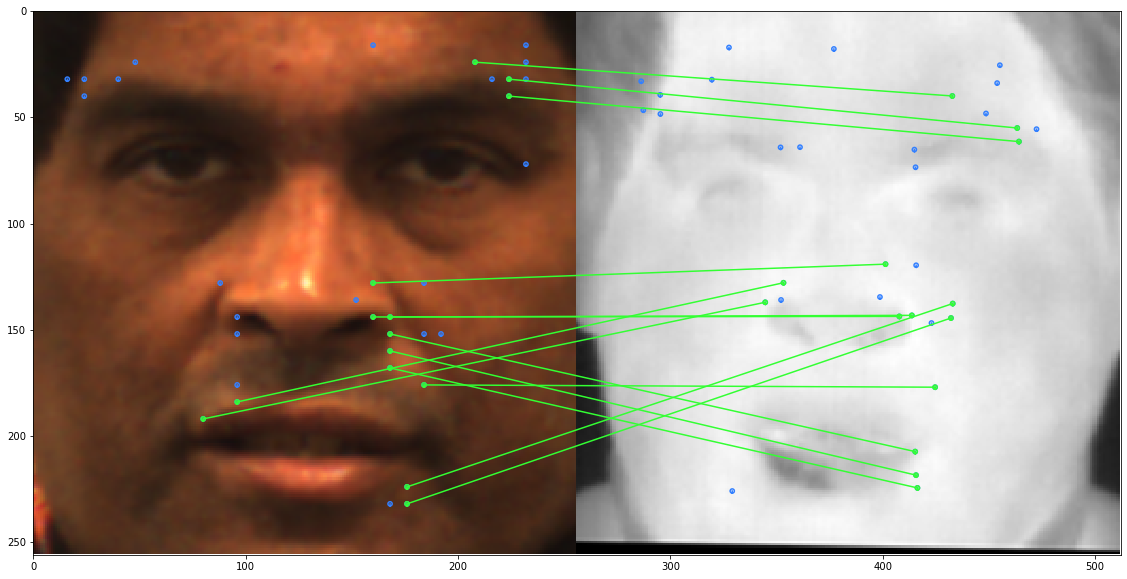

In [10]:
draw_LAF_matches(
    KF.laf_from_center_scale_ori(torch.from_numpy(mkpts0).view(1,-1, 2),
                                torch.ones(mkpts0.shape[0]).view(1,-1, 1, 1),
                                torch.ones(mkpts0.shape[0]).view(1,-1, 1)),

    KF.laf_from_center_scale_ori(torch.from_numpy(mkpts1).view(1,-1, 2),
                                torch.ones(mkpts1.shape[0]).view(1,-1, 1, 1),
                                torch.ones(mkpts1.shape[0]).view(1,-1, 1)),
    
    torch.arange(mkpts0.shape[0]).view(-1,1).repeat(1,2),
    
    K.tensor_to_image(img1),
    
    K.tensor_to_image(img2),
    
    inliers,
    
    draw_dict={'inlier_color': (0.2, 1, 0.2),# green, inliers epipolar lines
               'tentative_color': None,
               'feature_color': (0.2, 0.5, 1), # blue
               'vertical': False})

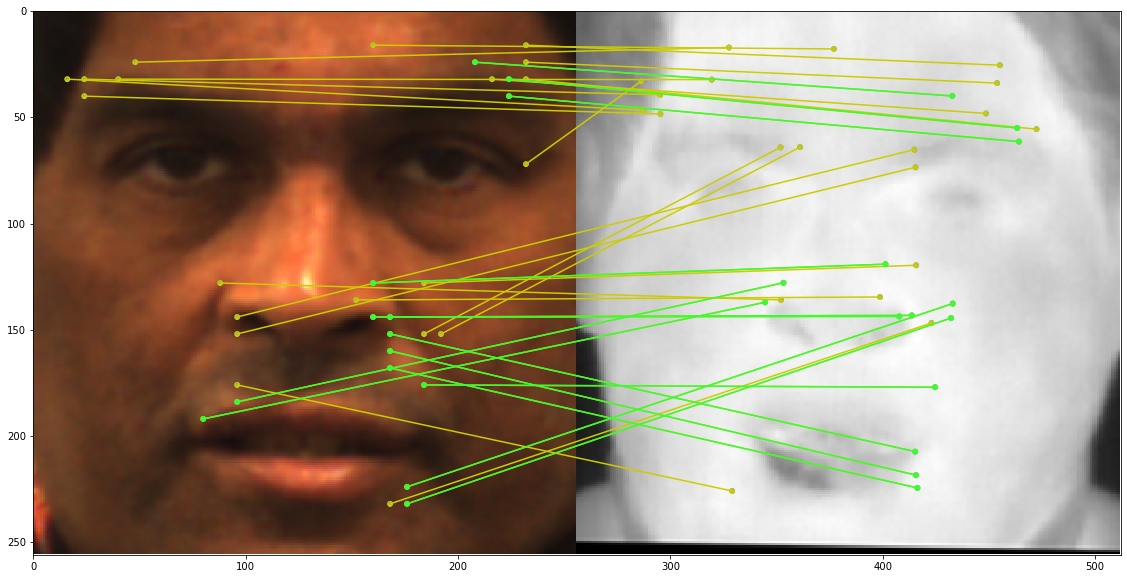

In [11]:
draw_LAF_matches(
    KF.laf_from_center_scale_ori(torch.from_numpy(mkpts0).view(1,-1, 2),
                                torch.ones(mkpts0.shape[0]).view(1,-1, 1, 1),
                                torch.ones(mkpts0.shape[0]).view(1,-1, 1)),

    KF.laf_from_center_scale_ori(torch.from_numpy(mkpts1).view(1,-1, 2),
                                torch.ones(mkpts1.shape[0]).view(1,-1, 1, 1),
                                torch.ones(mkpts1.shape[0]).view(1,-1, 1)),
    
    torch.arange(mkpts0.shape[0]).view(-1,1).repeat(1,2),
    
    K.tensor_to_image(img1),
    
    K.tensor_to_image(img2),
    
    inliers,
    
    draw_dict={'inlier_color': (0.2, 1, 0.2), # green lines
               'tentative_color': (0.8, 0.8, 0), # yellow lines
               'feature_color': (0.2, 0.5, 1), # blue
               'vertical': False})

In [12]:
print(mkpts0)

[[160.  16.]
 [232.  16.]
 [ 48.  24.]
 [208.  24.]
 [232.  24.]
 [ 16.  32.]
 [ 24.  32.]
 [ 40.  32.]
 [216.  32.]
 [224.  32.]
 [232.  32.]
 [ 24.  40.]
 [224.  40.]
 [232.  72.]
 [ 88. 128.]
 [160. 128.]
 [184. 128.]
 [152. 136.]
 [ 96. 144.]
 [160. 144.]
 [168. 144.]
 [ 96. 152.]
 [168. 152.]
 [184. 152.]
 [192. 152.]
 [168. 160.]
 [168. 168.]
 [ 96. 176.]
 [184. 176.]
 [ 96. 184.]
 [ 80. 192.]
 [176. 224.]
 [168. 232.]
 [176. 232.]]


In [13]:
print(mkpts1)

[[121.008224  17.768642]
 [199.18088   25.423126]
 [ 71.60922   17.078278]
 [176.78502   39.91807 ]
 [197.89272   33.851833]
 [ 31.264566  46.605427]
 [ 39.229687  39.3749  ]
 [ 63.537304  32.219917]
 [192.6478    48.143555]
 [207.35255   55.00948 ]
 [216.43997   55.54853 ]
 [ 39.305317  48.391502]
 [208.16257   61.40438 ]
 [ 30.255432  32.979748]
 [ 96.12287  135.97876 ]
 [145.32338  119.12139 ]
 [159.74368  119.63921 ]
 [142.70927  134.58452 ]
 [158.92383   65.17528 ]
 [151.82237  143.73271 ]
 [157.73111  143.2407  ]
 [159.47415   73.48213 ]
 [159.30109  207.40018 ]
 [ 95.8875    64.12052 ]
 [105.06385   64.02655 ]
 [159.68387  218.48572 ]
 [160.36241  224.5005  ]
 [ 73.146545 225.95383 ]
 [168.6727   177.06668 ]
 [ 97.26822  127.8913  ]
 [ 88.67222  137.08275 ]
 [176.96983  137.68257 ]
 [166.97589  146.8373  ]
 [176.16515  144.49486 ]]


In [14]:
# Number of points are equivalent to the inliers that get mapped on the image drawn
print(len(mkpts0))
print(len(mkpts1))
print(len(inliers))
print("*****")
print(mkpts0[0])
print(mkpts0[0][1])
print(mkpts1[0])
print(mkpts1[0][1])

34
34
34
*****
[160.  16.]
16.0
[121.008224  17.768642]
17.768642


In [15]:
dY = mkpts1[0][1] - mkpts0[0][1]
dX = mkpts1[0][0] - mkpts0[0][0]
print(dY, dX)
angle = np.degrees(np.arctan2(dY, dX)) 

1.7686424 -38.991776


In [16]:
print(angle)

177.40288


In [17]:
angles = []
for i in range(0, len(inliers)):
    dY = mkpts1[i][1] - mkpts0[i][1]
    dX = mkpts1[i][0] - mkpts0[i][0]
    angle = np.degrees(np.arctan2(dY, dX)) 
    angles.append(angle)
    
print("Average angle:", np.array(angles).mean())

Average angle: 2.2291703


In [30]:
angles

[177.40288,
 163.98,
 -16.340015,
 152.9807,
 163.88872,
 43.73586,
 25.838354,
 0.535319,
 145.3436,
 125.88587,
 123.45529,
 28.734798,
 126.49831,
 -169.05334,
 44.48721,
 -148.82819,
 -160.98169,
 -171.33734,
 -51.400494,
 -178.12793,
 -175.77118,
 -51.047787,
 98.92369,
 -135.07587,
 -134.6602,
 98.09268,
 97.69842,
 114.58369,
 176.019,
 -88.70516,
 -81.026276,
 -89.35626,
 -90.68896,
 -89.89186]

In [31]:
len(angles)

34

In [97]:
print("Average angle:", abs(np.array(angles)).mean())

Average angle: 110.011086


The mean doesn't account for outliers. To the human eye, at least for this image, the `Og_A` and the `Al_B` looks better than when both are aligned. As a result try: 

- How many inliers are there, we already know this
- Out of these inliers, how many are close to 0.00? Meaning about +/- 5.00 
- What is this percentage? 
- Could I establish a threshold, to weight these heavier? 



In [38]:
(np.array(angles)).hist

AttributeError: 'numpy.ndarray' object has no attribute 'hist'

In [33]:
(np.array(angles)).std()

121.79579

In [51]:
f = np.where((np.array(angles)<= 50.0) & (np.array(angles) >= -50.0))
f

(array([ 2,  5,  6,  7, 11, 14]),)

In [53]:
len(f[0])

6

In [56]:
print(len(f[0])/len(inliers) * 100)

17.647058823529413


<img src=./Atan2_60.svg.png>

<img src=./loftr_points_analysis.png>

This makes sense because the `y` coordinate doesn't change a lot in the below case. `mkpts1` `y = 32.219917` and `mkpts0` `y=32.`. Hence, the angle between them is very slight at `0.535319`.



In [84]:
dY = mkpts1[7][1] - mkpts0[7][1]
dX = mkpts1[7][0] - mkpts0[7][0]
print(mkpts0[7])
print(mkpts1[7])
print(dY, dX)
angle = np.degrees(np.arctan2(dY, dX)) 
print("angle:", angle)

[40. 32.]
[63.537304 32.219917]
0.2199173 23.537304
angle: 0.535319


In [100]:
mkpts1[7]

array([63.537304, 32.219917], dtype=float32)

In [101]:
mkpts0[7]

array([40., 32.], dtype=float32)

In [85]:
print(mkpts0[13])
print(mkpts1[13])

dY = mkpts1[13][1] - mkpts0[13][1]
dX = mkpts1[13][0] - mkpts0[13][0]
print(dX, dY)
angle = np.degrees(np.arctan2(dY, dX)) 
print("angle:", angle)

[232.  72.]
[30.255432 32.979748]
-201.74457 -39.020252
angle: -169.05334


### Report 

- Og_A, Al_B, Average angle: -27.937592
- Og_A, Og_B, Average angle: 42.710854
- Al_A, Al_B, Average angle: 2.2291703